In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [24]:
def numpy_ewma_vectorized_v2(data, window=20):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

def plot_logs(train_logs, time=True):
    avg_reward = numpy_ewma_vectorized_v2(np.array(train_logs['total_reward']))
    plt.plot(train_logs['time'],avg_reward , label = train_logs['info_summary'])
    plt.xlabel('time(in minutes)')
    plt.ylabel('avg_reward')
    plt.title('Avg reward vs Time')
    plt.legend()
    plt.show()         

             
    plt.plot(avg_reward, label = train_logs['info_summary'])
    plt.xlabel(train_logs['x'])
    plt.ylabel('avg_reward')
    plt.title('Avg reward vs ' + train_logs['x'])
    plt.legend()
    plt.show()         
             

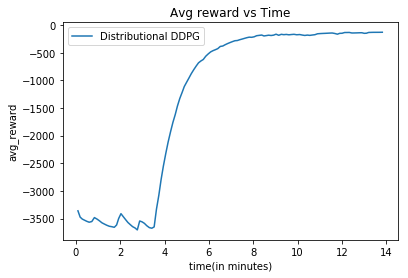

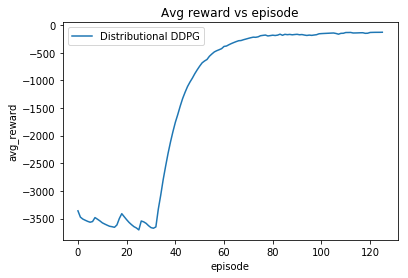

In [26]:
with open('train_logs_20180608-203928.pkl', 'rb') as fHandle:
    train_logs = pickle.load(fHandle)
plot_logs(train_logs)